# RAVDESS Model 2

.. WIP ..

In [9]:
#load the data
import csv
import numpy as np

labels = np.load('processing_dataset/labels.npy')
# Extract the onehot encoded labels
MFCCs = np.load("final_dataset/mfccs.npy")
print("MFCCs load finished")

dico_classes = {
                '02':'Calm',
                '03':'Happy',
                '04':'Sad',
                '05':'Angry',
                '06':'Fearful',
                '07':'Disgust'}

MFCCs load finished


In [10]:
# Use the get_dummies function to one-hot encode the labels
import pandas as pd
one_hot = pd.get_dummies(labels)


In [11]:
#Split data Train/validation
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split

# Convert the one-hot encoded DataFrame to a tensor
labels = torch.tensor(one_hot.values, dtype=torch.float32)

# split the data into training and validation sets
MFCCs = torch.tensor(MFCCs)
train_MFCCs, val_MFCCs, train_labels, val_labels = train_test_split(MFCCs, labels, test_size=0.25, random_state=42)
# normalize the spectrograms
train_MFCCs /= 255.0
val_MFCCs /= 255.0

# convert the lists to TensorFlow tensors
train_MFCCs = tf.convert_to_tensor(train_MFCCs, dtype=tf.float32)
val_MFCCs = tf.convert_to_tensor(val_MFCCs, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.int32)

# add a channel dimension to the spectrograms
train_MFCCs = tf.expand_dims(train_MFCCs, axis=-1)
val_MFCCs = tf.expand_dims(val_MFCCs, axis=-1)

In [12]:
#model creation

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D

model = Sequential()
# Define CNN model architecture
model.add(Conv1D(32, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(len(dico_classes)))
model.add(Activation('softmax'))

model.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 40, 32)            192       
                                                                 
 activation_6 (Activation)   (None, 40, 32)            0         
                                                                 
 dropout_4 (Dropout)         (None, 40, 32)            0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 10, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 64)            10304     
                                                                 
 activation_7 (Activation)   (None, 10, 64)            0         
                                                      

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_MFCCs, train_labels, batch_size=32, epochs=600, validation_data=(val_MFCCs, val_labels))

Epoch 1/600
27/27 [==============================] - 1s 13ms/step - loss: 1.7792 - accuracy: 0.1802 - val_loss: 1.7639 - val_accuracy: 0.1555
Epoch 2/600
27/27 [==============================] - 0s 5ms/step - loss: 1.7410 - accuracy: 0.2297 - val_loss: 1.7184 - val_accuracy: 0.2756
Epoch 3/600
27/27 [==============================] - 0s 6ms/step - loss: 1.6866 - accuracy: 0.2792 - val_loss: 1.6627 - val_accuracy: 0.2544
Epoch 4/600
27/27 [==============================] - 0s 5ms/step - loss: 1.6056 - accuracy: 0.3121 - val_loss: 1.5846 - val_accuracy: 0.3110
Epoch 5/600
27/27 [==============================] - 0s 5ms/step - loss: 1.5303 - accuracy: 0.3392 - val_loss: 1.5498 - val_accuracy: 0.3039
Epoch 6/600
27/27 [==============================] - 0s 5ms/step - loss: 1.4845 - accuracy: 0.3710 - val_loss: 1.4824 - val_accuracy: 0.3145
Epoch 7/600
27/27 [==============================] - 0s 6ms/step - loss: 1.4540 - accuracy: 0.3710 - val_loss: 1.4339 - val_accuracy: 0.4205
Epoch 8/600


9/9 [==============================] - 0s 1ms/step


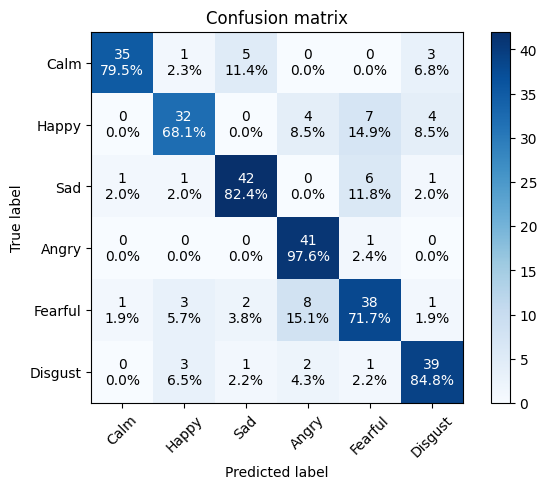

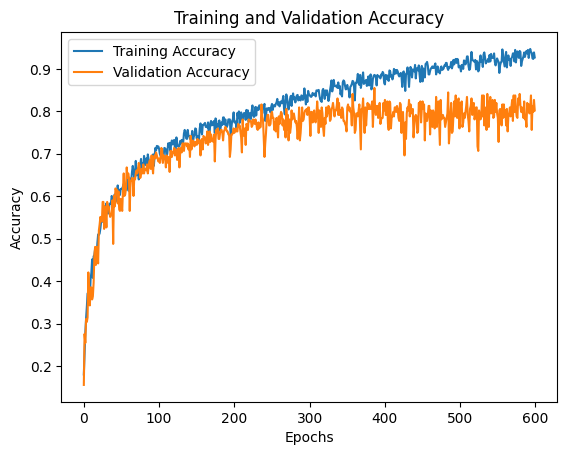

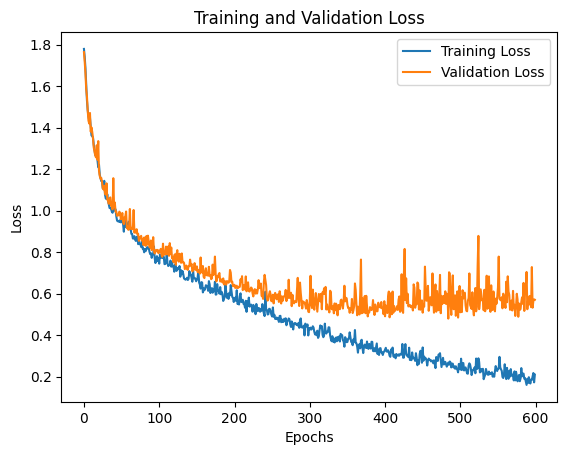

In [14]:
#results and analysis

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predicted labels
pred_labels = np.argmax(model.predict(val_MFCCs), axis=1)

# Convert the one-hot encoded labels to integer labels
val_labels_int = np.argmax(val_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels_int, pred_labels)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
# Add value percentages to each tile
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd') + '\n' + format(cm_percent[i, j] * 100, '.1f') + '%',
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
tick_marks = np.arange(len(dico_classes))
plt.xticks(tick_marks, dico_classes.values(), rotation=45)
plt.yticks(tick_marks, dico_classes.values())
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Get the training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a line plot of the training and validation accuracy values
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Create a line plot of the training and validation loss values
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
# Save the model
model.save('RAVDESS_model2.h5')
